# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Описание данных

#### Признаки


 - DateCrawled — дата скачивания анкеты из базы
 - VehicleType — тип автомобильного кузова
 - RegistrationYear — год регистрации автомобиля
 - Gearbox — тип коробки передач
 - Power — мощность (л. с.)
 - Model — модель автомобиля
 - Kilometer — пробег (км)
 - RegistrationMonth — месяц регистрации автомобиля
 - FuelType — тип топлива
 - Brand — марка автомобиля
 - NotRepaired — была машина в ремонте или нет
 - DateCreated — дата создания анкеты
 - NumberOfPictures — количество фотографий автомобиля
 - PostalCode — почтовый индекс владельца анкеты (пользователя)
 - LastSeen — дата последней активности пользователя


#### Целевой признак

 - Price — цена (евро)

### Загрузка и изучение данных

In [1]:
# импорт необходимых библитоек и функций:
import pandas as pd
import numpy as np

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

from math import sqrt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Предоработка

Проверим количество дубликатов:

In [4]:
df.duplicated().sum()

4

Даже такое небольшое количество дубликатов может повлиять на результат. Их необходимо удалить.

In [5]:
df = df.drop_duplicates()
df.duplicated().sum()

0

От дубликтов избавились. Теперь необходимо проверить пропуски.

In [6]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [7]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Пропуски есть в столбцах VehicleType, Gearbox, Model, FuelType, NotRepaired. Они занимают достаточно большой объем от датасета, поэтому удалять их - значит повлиять на работу модели. Стоит их заменить. Столбец VehicleType - тип кузова. Врядли его можно заменить релевантным значением. Заменим пропуски на unknow. Также поступим с пропусками в всех отсальных столбцах. 

In [8]:
df = df.fillna('unknow')
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Далее удалим неполезные для нас данные, которые не влияют на цену автомобиля. Это информация о почтовом индексе, количестве фотографий, дате создания объявления и месяц регистраци автомобиля.

In [9]:
df = df.drop(['NumberOfPictures', 'PostalCode', 'DateCrawled', 'RegistrationMonth'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       354365 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           354365 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             354365 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          354365 non-null  object
 8   Brand             354365 non-null  object
 9   NotRepaired       354365 non-null  object
 10  DateCreated       354365 non-null  object
 11  LastSeen          354365 non-null  object
dtypes: int64(4), object(8)
memory usage: 35.1+ MB


Теперь посмотрим на наличие выборосов и адекватность данных. Начнем с цены.

<AxesSubplot:ylabel='Frequency'>

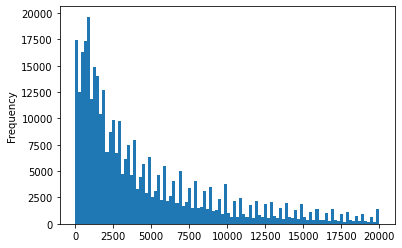

In [10]:
df['Price'].plot(kind='hist', bins=100)

Много данных с нулевыми ценами. Это странно. Дешевле 10 тысяч рублей это сильно странно. Посмотрим на объявления с ценой меньше 100 евро.

In [11]:
df[df['Price'] < 100]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated,LastSeen
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no,2016-03-21 00:00:00,2016-03-25 16:47:58
40,0,unknow,1990,unknow,0,corsa,150000,petrol,opel,unknow,2016-03-26 00:00:00,2016-03-27 17:43:34
59,1,suv,1994,manual,286,unknow,150000,unknow,sonstige_autos,unknow,2016-03-29 00:00:00,2016-04-06 01:44:38
89,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no,2016-03-28 00:00:00,2016-04-06 12:15:54
111,0,unknow,2017,manual,0,golf,5000,petrol,volkswagen,unknow,2016-03-19 00:00:00,2016-04-01 08:47:05
...,...,...,...,...,...,...,...,...,...,...,...,...
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,unknow,2016-03-20 00:00:00,2016-04-06 18:45:23
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,unknow,2016-03-24 00:00:00,2016-04-07 05:17:24
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes,2016-03-10 00:00:00,2016-03-12 23:46:32
354309,99,small,1999,manual,60,arosa,150000,petrol,seat,yes,2016-03-09 00:00:00,2016-04-06 22:15:32


Данные о цене этих авто явно не получится восстановить. Их стоит удалить. 

<AxesSubplot:ylabel='Frequency'>

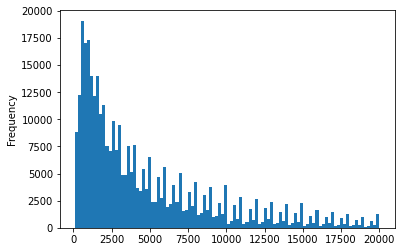

In [12]:
df = df[df['Price'] > 100]
df['Price'].plot(kind='hist', bins=100)

Следующий столбец для проверки на выбросы - год регистрации.

In [13]:
df[df['RegistrationYear'] > 2022]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated,LastSeen
15870,1700,unknow,3200,unknow,0,unknow,5000,unknow,sonstige_autos,unknow,2016-04-02 00:00:00,2016-04-06 09:46:13
17271,700,unknow,9999,unknow,0,other,10000,unknow,opel,unknow,2016-03-23 00:00:00,2016-04-05 20:16:15
17346,6500,unknow,8888,unknow,0,unknow,10000,unknow,sonstige_autos,unknow,2016-03-06 00:00:00,2016-03-30 20:46:55
18259,300,unknow,2200,unknow,0,twingo,5000,unknow,renault,unknow,2016-03-16 00:00:00,2016-04-07 06:45:32
20159,1600,unknow,4100,unknow,0,unknow,5000,unknow,sonstige_autos,unknow,2016-04-01 00:00:00,2016-04-05 20:19:27
...,...,...,...,...,...,...,...,...,...,...,...,...
320452,500,unknow,8200,auto,81,octavia,10000,unknow,skoda,unknow,2016-03-16 00:00:00,2016-03-16 08:52:33
322234,15000,unknow,5000,unknow,155,golf,5000,petrol,volkswagen,unknow,2016-03-24 00:00:00,2016-04-07 11:16:25
326556,7999,unknow,5911,auto,75,golf,10000,unknow,volkswagen,unknow,2016-03-29 00:00:00,2016-04-06 07:46:20
328453,450,unknow,2500,unknow,0,6_reihe,5000,unknow,mazda,unknow,2016-03-14 00:00:00,2016-03-19 07:17:39


В этих объявлениях явно неверные данные, их стоит удалить, так как они будут мешать построению модели.

In [14]:
df = df[df['RegistrationYear'] < 2022]

Теперь посмотрим на аномально низкие значения в годе регистрации автомобиля:

In [15]:
df[df['RegistrationYear'] < 1900]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated,LastSeen
16062,190,unknow,1000,unknow,0,mondeo,5000,unknow,ford,unknow,2016-03-29 00:00:00,2016-04-06 10:44:58
18224,7999,unknow,1500,manual,224,impreza,5000,unknow,subaru,unknow,2016-03-09 00:00:00,2016-03-15 05:15:17
34332,450,unknow,1800,unknow,1800,unknow,5000,unknow,mitsubishi,no,2016-04-01 00:00:00,2016-04-01 09:42:30
38875,1234,unknow,1234,unknow,26,unknow,5000,unknow,trabant,unknow,2016-03-19 00:00:00,2016-04-06 03:15:22
53577,330,unknow,1000,unknow,0,polo,5000,unknow,volkswagen,unknow,2016-03-20 00:00:00,2016-04-04 08:17:15
55605,500,unknow,1000,unknow,0,unknow,5000,unknow,citroen,yes,2016-03-10 00:00:00,2016-04-06 03:45:53
56241,950,unknow,1400,manual,1400,golf,125000,petrol,volkswagen,unknow,2016-03-30 00:00:00,2016-04-03 09:45:19
66198,1300,unknow,1000,auto,0,unknow,5000,petrol,sonstige_autos,unknow,2016-03-08 00:00:00,2016-03-17 08:17:42
71459,500,unknow,1000,unknow,0,golf,5000,unknow,volkswagen,unknow,2016-03-27 00:00:00,2016-03-29 13:46:49
79120,4750,unknow,1000,unknow,0,other,5000,unknow,renault,unknow,2016-03-15 00:00:00,2016-04-06 20:19:21


Их тоже немного, но они явно не правдоподобны, также исключим их. 

In [16]:
df = df[df['RegistrationYear'] > 1900]

Теперь посмотрим на мощьность двигателя. Посмотрим на мощность двиготеля менее 5 л.с., так как именно столько по закону должны иметь транспортные средства.

In [17]:
df[df['Power'] < 5]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated,LastSeen
0,480,unknow,1993,manual,0,golf,150000,petrol,volkswagen,unknow,2016-03-24 00:00:00,2016-04-07 03:16:57
15,450,small,1910,unknow,0,ka,5000,petrol,ford,unknow,2016-03-11 00:00:00,2016-03-19 08:46:47
32,245,sedan,1994,unknow,0,golf,150000,petrol,volkswagen,no,2016-03-15 00:00:00,2016-03-17 18:17:43
37,1500,unknow,2016,unknow,0,kangoo,150000,gasoline,renault,no,2016-03-28 00:00:00,2016-03-30 09:18:02
54,4700,wagon,2005,manual,0,signum,150000,unknow,opel,no,2016-03-17 00:00:00,2016-04-04 04:17:32
...,...,...,...,...,...,...,...,...,...,...,...,...
354338,180,unknow,1995,unknow,0,unknow,125000,petrol,opel,unknow,2016-03-31 00:00:00,2016-04-06 14:18:04
354346,2600,unknow,2005,auto,0,c_klasse,150000,unknow,mercedes_benz,unknow,2016-03-07 00:00:00,2016-03-08 21:28:38
354360,3999,wagon,2005,manual,3,3er,150000,gasoline,bmw,no,2016-04-02 00:00:00,2016-04-06 20:47:12
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no,2016-03-27 00:00:00,2016-03-29 10:17:23


Так как данных слишком много, не будем их удалять, попробуем заменить данные средним значением по модели. Включим в условия и данные о количестве сил более 1000. 

In [18]:
df.loc[(df['Power'] > 1000) | (df['Power'] <= 5), 'Power'] = None
df['Power'] = df['Power'].fillna(df.groupby('Model')['Power'].transform('median'))

In [19]:
df[df['Power'] < 5]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated,LastSeen


Признаки DateCreated и LastSeen:

In [20]:
min(df['DateCreated'])

'2014-03-10 00:00:00'

Признаки DateCreated и LastSeen преобразуем в количество дней с момента 2014-03-01.

In [21]:
base_df = pd.Timestamp('2014-03-01 00:00:00')
df['DateCreated'] = df['DateCreated'].map(lambda date : (pd.Timestamp(date) - base_df).days)
df['LastSeen'] = df['LastSeen'].map(lambda date : (pd.Timestamp(date) - base_df).days)

Данные очищены от выбросов и пропусков. Взглянем на них еще раз:

In [22]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated,LastSeen
0,480,unknow,1993,manual,101.0,golf,150000,petrol,volkswagen,unknow,754,768
1,18300,coupe,2011,manual,190.0,unknow,125000,gasoline,audi,yes,754,768
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknow,744,766
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no,747,747
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no,761,767


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339909 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             339909 non-null  int64  
 1   VehicleType       339909 non-null  object 
 2   RegistrationYear  339909 non-null  int64  
 3   Gearbox           339909 non-null  object 
 4   Power             339908 non-null  float64
 5   Model             339909 non-null  object 
 6   Kilometer         339909 non-null  int64  
 7   FuelType          339909 non-null  object 
 8   Brand             339909 non-null  object 
 9   NotRepaired       339909 non-null  object 
 10  DateCreated       339909 non-null  int64  
 11  LastSeen          339909 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 33.7+ MB


### Кодирование категориальных признаков

Для преобразования категориальных признаков используем функцию get_dummies() с аргументом drop_first. Такой подход позволит не попасть в дамми-ловушку, так как не создает большое количество фиктивных признаков. 

In [24]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.head()

,Price,RegistrationYear,Power,Kilometer,DateCreated,LastSeen,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknow,NotRepaired_yes
0,480,1993,101.0,150000,754,768,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011,190.0,125000,754,768,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163.0,125000,744,766,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75.0,150000,747,747,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69.0,90000,761,767,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Разбиение данных на выборки

Так как спрятанной тестовой выборки у нас нету, разделим исходные данные на три выборки: обучающую, валидационную и тестовую. Так как размеры тестовой и валидационной выборок обычно равны, разделим данные в соотношении 3:1:1.

Для этого методом train_test_split разделим исходные данные на обучающую (60%) и валидационную выборку (40%), а после этого валидационную выборку разделим пополам — на валидационную и тестовую выборки

In [25]:
# разделим признаки и целевой признак:
target = df_ohe['Price']
features = df_ohe.drop('Price', axis=1)

In [26]:
# поделим данные на обучающую и валидацилнную выборки:
features_train, features_valid, target_train, target_valid = train_test_split(features,
target, train_size=0.60, test_size=0.40, random_state=12345)

# и валидационную поделим на валидационную и тестовую:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
target_valid, train_size=0.50, test_size=0.50, random_state=12345)

## Обучение моделей

Используем несколько моделей для поиска лучшего результата. Для этого возьмем линейную регрессию, LGBM и CatBoost. 

### LinearRegression

Для линейной регрессии нужно масштабировать признаки. 

In [27]:
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'DateCreated', 'LastSeen']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [28]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [29]:
features_train.sample()

,RegistrationYear,Power,Kilometer,DateCreated,LastSeen,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknow,NotRepaired_yes
252465,-0.168417,-0.192771,0.579299,-0.195775,-1.148648,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Сейчас признаки имеют одинаковый масштаб.

Перед тем как перейти к обучению моделей, напишем функцию для расчета метрики RMSE. Данная метрика позволит оценить и сравнить качество разных моделей.

In [30]:
def rmse(target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = sqrt(mse)
    return rmse

Не знаю откуда, ну у меня затерялся один пропуск в Power и вылезала ошибка "Input contains NaN, infinity or a value too large for dtype('float64')". Поэтому чищу пропуски и идем дальше. 

In [31]:
features_train = features_train.fillna(0)

In [32]:
%%time
lm = LinearRegression()
lm.fit(features_train, target_train)

CPU times: user 17.3 s, sys: 3.9 s, total: 21.2 s
Wall time: 21.2 s


LinearRegression()

In [33]:
%%time
predictions_lm = lm.predict(features_test)

CPU times: user 79.1 ms, sys: 78 ms, total: 157 ms
Wall time: 128 ms


In [34]:
print('RMSE на тестовой выборке:', rmse(target_test, predictions_lm))

RMSE на тестовой выборке: 2630.7823933017557


### LGBMRegressor

Подберем параметры и обучим модель.

In [35]:
parameters = {'boosting_type': 'gbdt', 
              'max_depth': 11, 
              'n_estimators': 120, 
              'random_state': 12345}
model_lgbm = LGBMRegressor(**parameters)

In [36]:
%%time
model_lgbm.fit(features_train, target_train)

CPU times: user 7.73 s, sys: 266 ms, total: 7.99 s
Wall time: 8.07 s


LGBMRegressor(max_depth=11, n_estimators=120, random_state=12345)

In [37]:
%%time
predictions_lgbm = model_lgbm.predict(features_test, verbose=2)

CPU times: user 877 ms, sys: 78 ms, total: 955 ms
Wall time: 944 ms


In [38]:
print('RMSE на тестовой выборке:', rmse(target_test, predictions_lgbm))

RMSE на тестовой выборке: 1693.489546452197


### CatBoostRegressor

In [39]:
%%time
results = []
for iteration in range(10, 101, 20):
    
    for depth in range(5, 11, 2):
    
        model_cbr = CatBoostRegressor(random_state=12345, iterations=iteration, loss_function='RMSE', depth=depth)
    

        model_cbr.fit(features_train, target_train)

 
        predictions_cbr = model_cbr.predict(features_test, verbose=1)


        RMSE = rmse(target_test, predictions_cbr)
        
        results.append({'Модель': 'CatBoostRegressor', 
                        'Параметры': {'random_state':12345, 
                                      'iterations': iteration, 
                                      'loss_function': 'RMSE', 
                                      'depth': depth}, 
                        'RMSE': RMSE})

Learning rate set to 0.5
0:	learn: 3286.2752311	total: 81ms	remaining: 729ms
1:	learn: 2725.4509035	total: 111ms	remaining: 444ms
2:	learn: 2474.3875297	total: 137ms	remaining: 320ms
3:	learn: 2311.6559801	total: 166ms	remaining: 248ms
4:	learn: 2225.2519144	total: 195ms	remaining: 195ms
5:	learn: 2171.9184131	total: 222ms	remaining: 148ms
6:	learn: 2124.3192395	total: 250ms	remaining: 107ms
7:	learn: 2097.6042696	total: 277ms	remaining: 69.2ms
8:	learn: 2073.0705682	total: 303ms	remaining: 33.7ms
9:	learn: 2049.4130820	total: 331ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3189.7012792	total: 35.2ms	remaining: 317ms
1:	learn: 2603.7138744	total: 71.4ms	remaining: 286ms
2:	learn: 2333.9267792	total: 107ms	remaining: 249ms
3:	learn: 2201.1928252	total: 141ms	remaining: 211ms
4:	learn: 2105.5329275	total: 176ms	remaining: 176ms
5:	learn: 2050.9974700	total: 206ms	remaining: 138ms
6:	learn: 2015.9028108	total: 238ms	remaining: 102ms
7:	learn: 1993.0996766	total: 271ms	remaining: 6

In [40]:
pd.DataFrame(results).style.highlight_min(color = 'lightgreen', axis = 0)

,Модель,Параметры,RMSE
0,CatBoostRegressor,"{'random_state': 12345, 'iterations': 10, 'loss_function': 'RMSE', 'depth': 5}",2041.034496
1,CatBoostRegressor,"{'random_state': 12345, 'iterations': 10, 'loss_function': 'RMSE', 'depth': 7}",1952.785445
2,CatBoostRegressor,"{'random_state': 12345, 'iterations': 10, 'loss_function': 'RMSE', 'depth': 9}",1871.414912
3,CatBoostRegressor,"{'random_state': 12345, 'iterations': 30, 'loss_function': 'RMSE', 'depth': 5}",1844.371272
4,CatBoostRegressor,"{'random_state': 12345, 'iterations': 30, 'loss_function': 'RMSE', 'depth': 7}",1785.914703
5,CatBoostRegressor,"{'random_state': 12345, 'iterations': 30, 'loss_function': 'RMSE', 'depth': 9}",1731.435794
6,CatBoostRegressor,"{'random_state': 12345, 'iterations': 50, 'loss_function': 'RMSE', 'depth': 5}",1783.947969
7,CatBoostRegressor,"{'random_state': 12345, 'iterations': 50, 'loss_function': 'RMSE', 'depth': 7}",1719.297347
8,CatBoostRegressor,"{'random_state': 12345, 'iterations': 50, 'loss_function': 'RMSE', 'depth': 9}",1677.671237
9,CatBoostRegressor,"{'random_state': 12345, 'iterations': 70, 'loss_function': 'RMSE', 'depth': 5}",1736.739229


## Анализ моделей

### Анализ моделей

Изучив данные трех моделей можно сделать следующие выводы:

- Модель линейной регрессии хоть и достаточно быстра, но имеет слишком большой показатель RMSE - 2630.
- Модель LGBM работает медленно, но показывает лучший результат, чем у линейной регрессии - RMSE равно почти 1693.
- Модель CatBoost работает быстрее, чем LGBM, и результат у нее немного лучше - RMSE равно 1628.

### Вывод

Исходя из вышеизложенного - лучший вариант это модель CatBoostRegressor.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей